## Exploratory Data Analsis on TweetEval

In this notebook, we analyze the tweets in each subset.

In [1]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from gensim.models import word2vec
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

%matplotlib inline


In [2]:
# load data
path = os.getcwd()
folder = path + "/cleaned_df/"

train = []
test = []
val = []

for file in sorted(os.listdir(folder)):
    fname = file.split('.')[0]
    df = pd.read_csv(folder + file)
    if re.search("train", fname):
        train.append(df)
    if re.search("test", fname):
        test.append(df)
    if re.search("validation", fname):
        val.append(df)

df_names = [file.split('stance_')[1] if 'stance_' in file else file for file in sorted(os.listdir(folder))]
df_names = [file.split('_')[0] for file in df_names]
df_names = sorted(set(df_names), key=df_names.index)

In [3]:
# dictionary to facilitate access to the dataframes
train_named = dict(zip(df_names, train))
test_named = dict(zip(df_names, test))
val_named = dict(zip(df_names, val))

### Distribution Plots

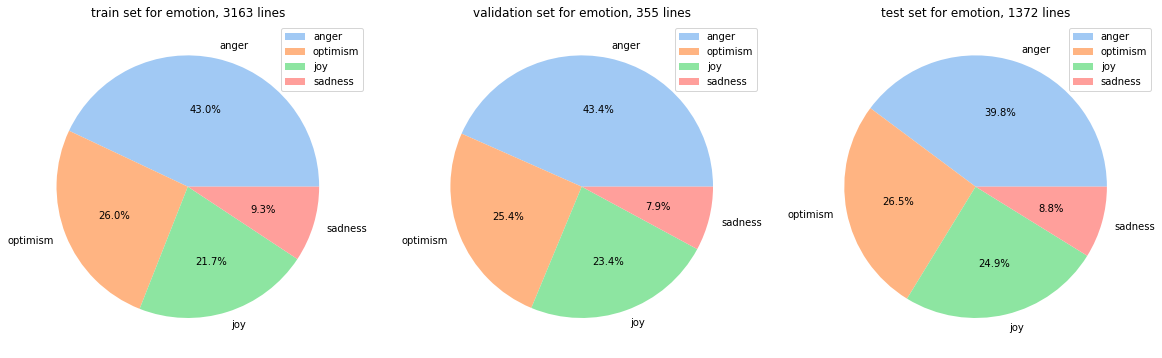

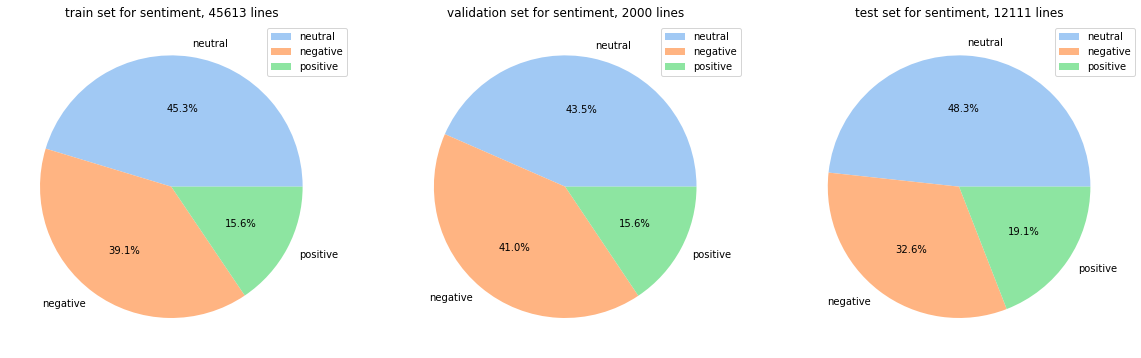

In [4]:
subset_names = ['emotion', 'sentiment']

# labels for each subset
emotion_labels = {0:'anger', 1:'optimism', 2:'joy', 3:'sadness'}
sentiment_labels = {0:'neutral', 1:'negative', 2:'positive'}

for subset in subset_names:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    for i, (df, name) in enumerate(zip([train_named[subset], val_named[subset], test_named[subset]], ['train', 'validation','test'])):
        y = df.label.value_counts().values / len(df) * 100
        if subset == 'emotion':
            df['label'] = df['label'].map(emotion_labels)
            labels = ['anger', 'optimism', 'joy', 'sadness']
        elif subset == 'sentiment':
            df['label'] = df['label'].map(sentiment_labels)
            labels = ['neutral', 'negative', 'positive']
        ax[i].pie(y, colors=sns.color_palette("pastel"), autopct='%1.1f%%', labels=labels)
        ax[i].legend(loc='upper right', bbox_to_anchor=(1.05, 1))
        ax[i].set_title(f'{name} set for {subset}, {len(df)} lines')
    plt.show()


<ipython-input-5-bbb79d8ecbb2>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-bbb79d8ecbb2>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-5-bbb79d8ecbb2>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


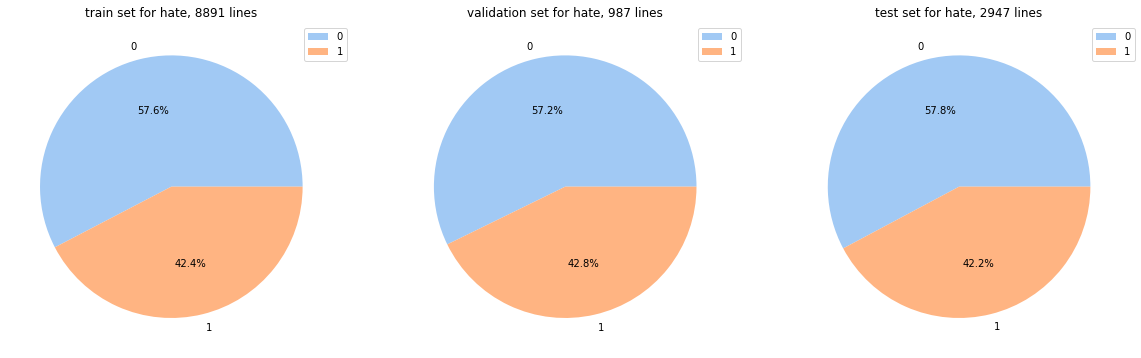

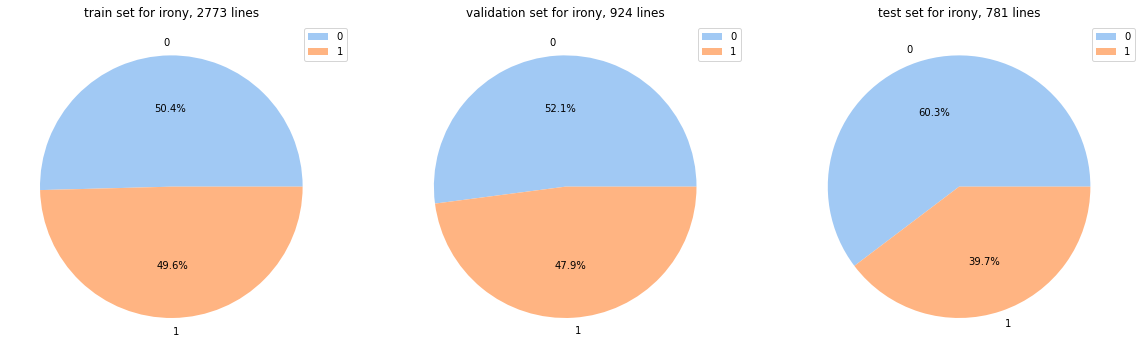

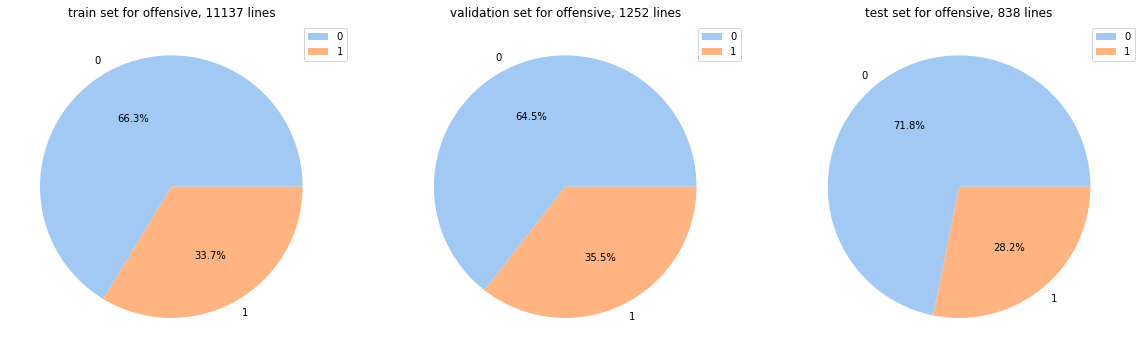

In [5]:
subset_names = ['hate', 'irony', 'offensive']

for subset in subset_names:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    for i, (df, name) in enumerate(zip([train_named[subset], val_named[subset], test_named[subset]], ['train', 'validation','test'])):
        y = df.label.value_counts().values / len(df) * 100
        ax[i].pie(y, colors=sns.color_palette("pastel"), autopct='%1.1f%%', labels=['0', '1'])
        ax[i].legend(loc='upper right', bbox_to_anchor=(1.05, 1))
        ax[i].set_title(f'{name} set for {subset}, {len(df)} lines')
    fig.show()

<ipython-input-6-6e7d97bf4ed9>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-6e7d97bf4ed9>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-6e7d97bf4ed9>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-6-6e7d97bf4ed9>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


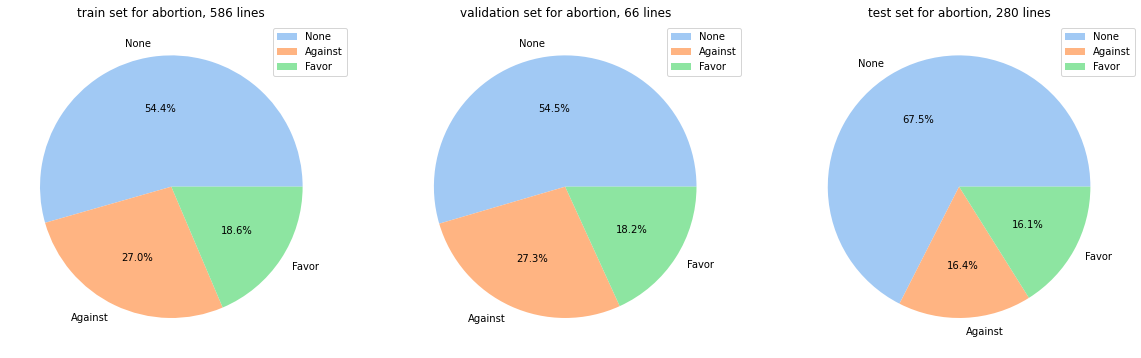

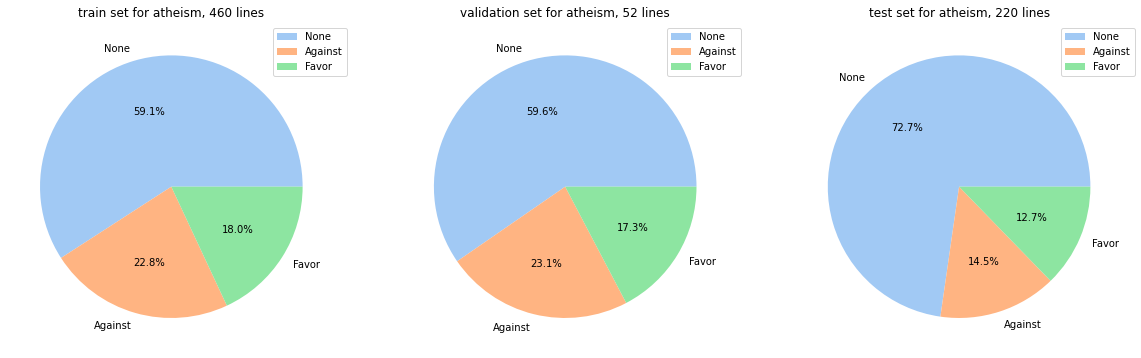

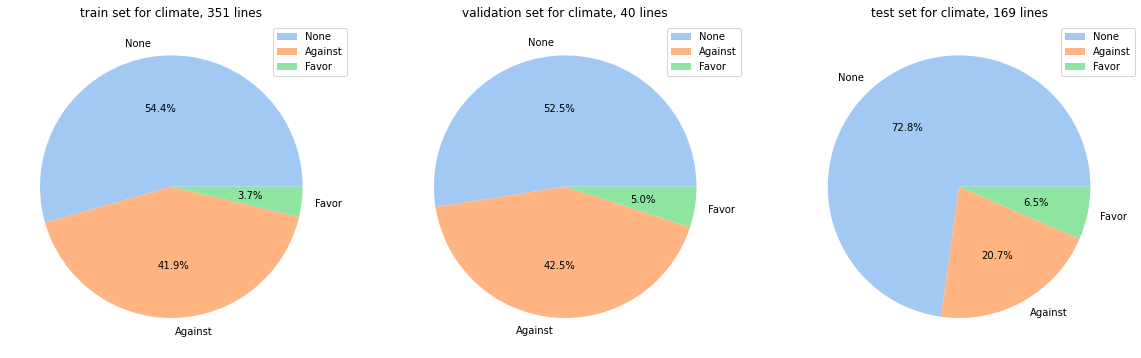

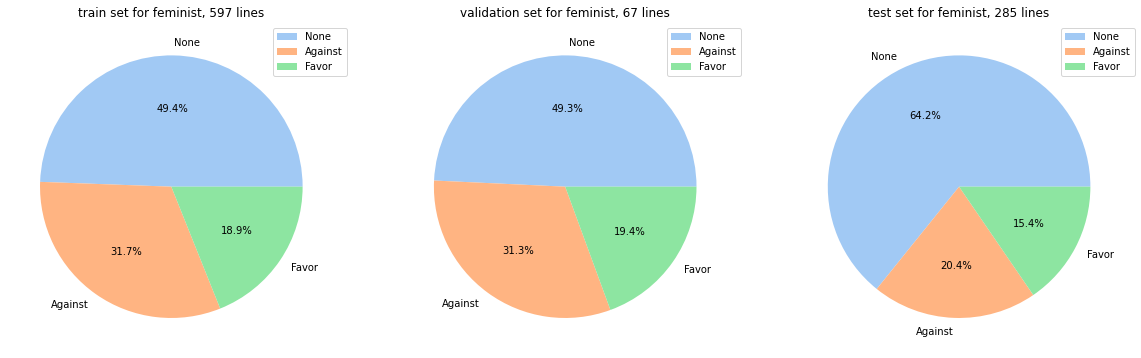

In [6]:
# Visualizing the distribution of support and opposition to topics

subset_names = ['abortion', 'atheism', 'climate', 'feminist']

for subset in subset_names:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 10))
    for i, (df, name) in enumerate(zip([train_named[subset], val_named[subset], test_named[subset]], ['train', 'validation','test'])):
        y = df.label.value_counts().values / len(df) * 100
        ax[i].pie(y, colors=sns.color_palette("pastel"), autopct='%1.1f%%', labels=['None', 'Against', 'Favor'])
        ax[i].legend(loc='upper right', bbox_to_anchor=(1.05, 1))
        ax[i].set_title(f'{name} set for {subset}, {len(df)} lines')
    fig.show()
    

### tSNE Plots

*Visualizing word vectors.* Here, I create and plot tSNE (t-Distributed Stochastic Neighbor Embedding) models for each stance subset.  In the model, I set the `min_count` proportional to the size of the dataset. This means that the model and the graph will only read words that appeared `min_count` times in the corpus.  The larger the number, the more words are excluded, vice versa.  For each stance, we will only focus on visualizing the training dataset since it is the largest, and allows for a neater organization for visualizing the graphs. 

In [7]:
def tsne_plot_2d(data, subset, ax):
    sns.set_style('whitegrid')
    
    labels = []
    tokens = []
    sentences = [text.split() for text in data.text] 
    model = word2vec.Word2Vec(sentences, window=20, min_count=np.floor(len(data)/70), workers=4)

    for word in model.wv.index_to_key:
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=4, n_components=2, init='pca', n_iter=2500, random_state=23, learning_rate='auto')
    embeddings_wp_2d = tsne_model.fit_transform(np.array(tokens))

    x = embeddings_wp_2d[:, 0]
    y = embeddings_wp_2d[:, 1]
        
    ax.set_title(f'2-Dimensional t-SNE Plot for {subset.upper()} subset')
    sns.scatterplot(x=x, y=y, color='indianred', ax=ax)
    for i in range(len(x)):
        ax.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


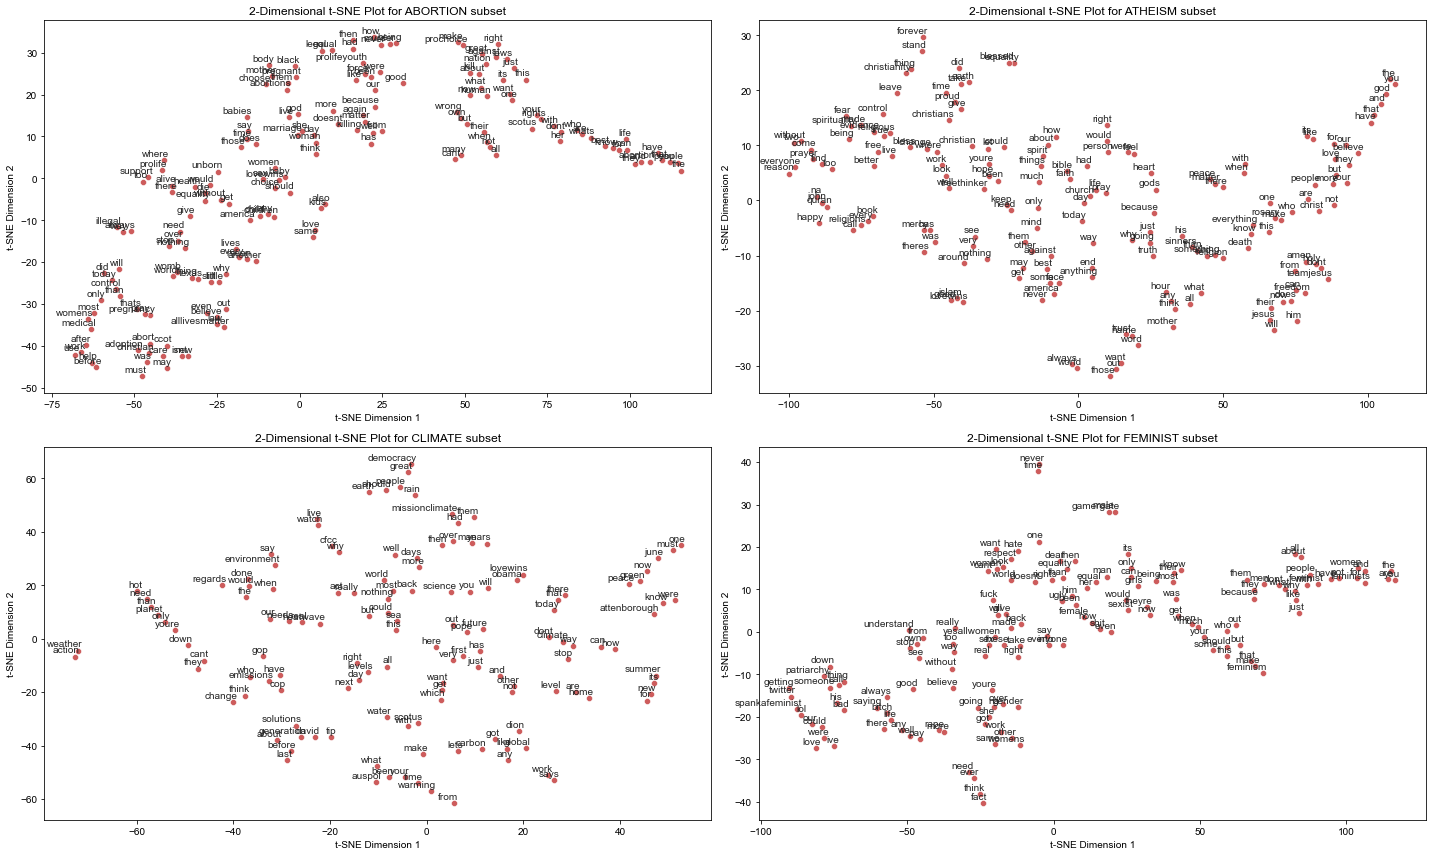

In [8]:
subset_names = ['abortion', 'atheism', 'climate', 'feminist']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
axes = axes.flatten()

for i, subset in enumerate(subset_names):
    tsne_plot_2d(train_named[subset], subset, axes[i]) # only use training sets

plt.tight_layout()
plt.show()

The findings are interesting.  For the `abortion` subset, the words are quite clustered with each other, meaning the words in tweets for this dataset tend to have similar meaning with each other.  On the other hand, this is the opposite for the `climate` subset, there is less of a similarity or order to the words in the subset. 

Next, we attempt to show the same graph with an added dimension.  The clusters are less obvious in 3-D, but it is still an interesting insight.

In [9]:
def tsne_plot_3d(data, subset, ax):
    sns.set_style('whitegrid')
    
    labels = []
    tokens = []
    sentences = [text.split() for text in data.text] 
    model = word2vec.Word2Vec(sentences, window=20, min_count=2, workers=4)

    for word in model.wv.index_to_key:
        tokens.append(model.wv.get_vector(word))
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=3, init='pca', n_iter=2500, random_state=23, learning_rate='auto')
    embeddings_wp = np.array(tokens)
    embeddings_wp_3d = tsne_model.fit_transform(embeddings_wp)

    x = embeddings_wp_3d[:, 0]
    y = embeddings_wp_3d[:, 1]
    z = embeddings_wp_3d[:, 2]

    ax.set_title(f'3-Dimensional t-SNE Plot for {subset.upper()} subset')
    ax.plot(x, y, z, '.', color='indianred', alpha=0.4)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


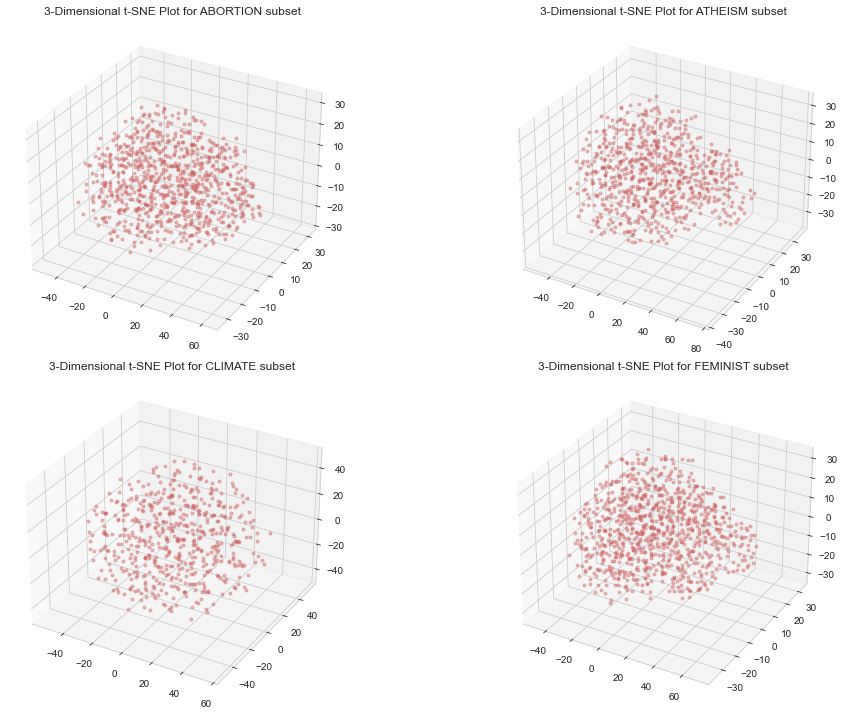

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10), subplot_kw=dict(projection='3d'))
axes = axes.flatten()

for i, subset in enumerate(subset_names):
    tsne_plot_3d(train_named[subset], subset, axes[i])

plt.tight_layout()
plt.show()

*Word frequency charts.* Here, we plot words that appear the most in each subset.

In [11]:
def word_freq_chart(data, subset, ax):
    words = data['text'].str.lower().str.split().explode()
    word_freq = words.value_counts().sort_values(ascending=False)
    
    # top 20 words by frequency
    top_words = word_freq.head(20)
    
    # bar chart
    ax.barh(top_words.index, top_words.values, color='indianred')
    ax.set_title(f'Top 15 Words by Frequency in {subset.upper()} Subset')
    ax.set_xlabel('Word')
    ax.set_ylabel('Frequency')
    ax.invert_yaxis()
    ax.tick_params(axis='x')

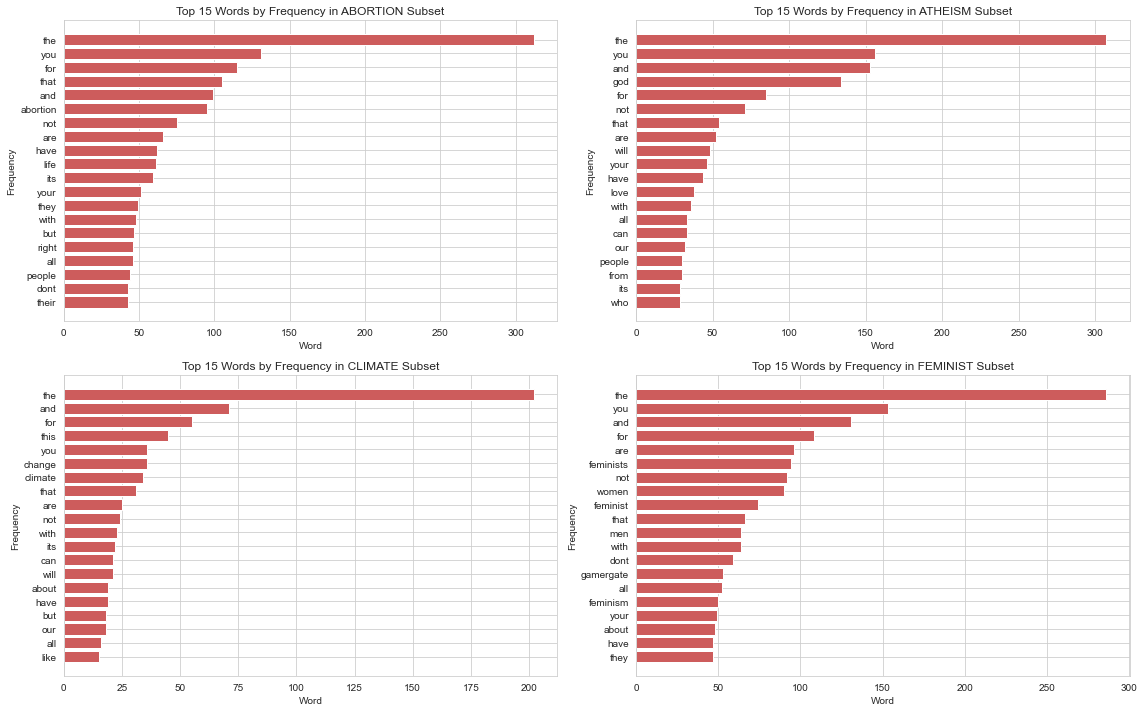

In [12]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

# plot
for i, subset in enumerate(subset_names):
    word_freq_chart(train_named[subset], subset, axes[i])

plt.tight_layout()
plt.show()

*Bigrams.* The bigram chart shows the pairs of words that appears most frequently in the same tweet, for each stance.  For example, some interesting words that 'feminist' is most often paired with are 'cat', 'gamergate', and 'identity'.  For 'abortion' we have 'clinics', 'illegal', and 'murder'.  For the atheism dataset, there are only 4 pairs of bigrams, which can indicate a small sample size for the dataset.

In [13]:
def get_top_bigrams(column, subset):
    text = " ".join(column)
    words = nltk.word_tokenize(text)
    bigram_finder = BigramCollocationFinder.from_words(words)

    word_filter = lambda w1, w2: subset not in (w1, w2)
    bigram_finder.apply_ngram_filter(word_filter)

    bigram_measures = BigramAssocMeasures()
    scored_bigrams = bigram_finder.score_ngrams(bigram_measures.raw_freq)

    return scored_bigrams[:20]


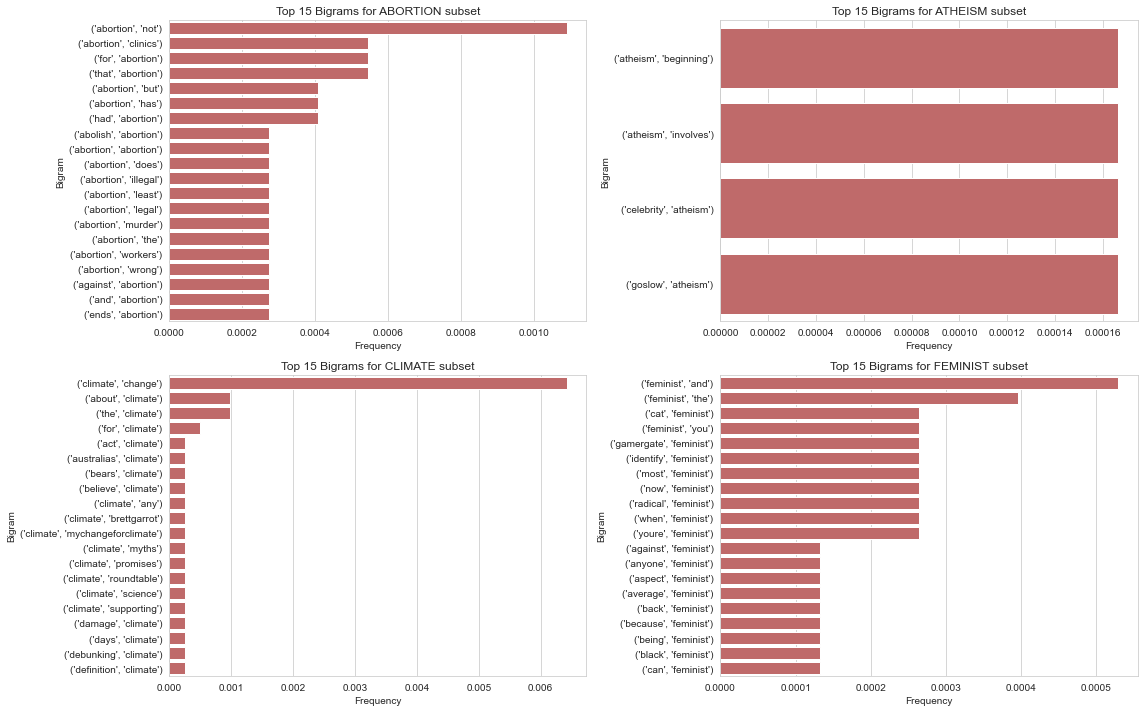

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = axes.flatten()

for i, subset in enumerate(subset_names):
    df = train_named[subset] # only use training sets
    
    top_bigrams = get_top_bigrams(df['text'], subset)
    bigrams_df = pd.DataFrame(top_bigrams, columns=['bigram', 'frequency'])

    sns.barplot(x='frequency', y='bigram', data=bigrams_df, color='indianred', ax=axes[i])
    axes[i].set_title(f'Top 15 Bigrams for {subset.upper()} subset')
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Bigram')

plt.tight_layout()
plt.show()

*Bigram networks.*  Here we show the top pairs for each subset using network graphs.

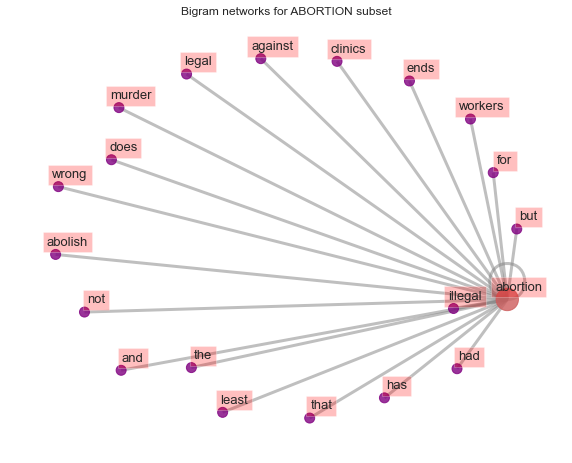

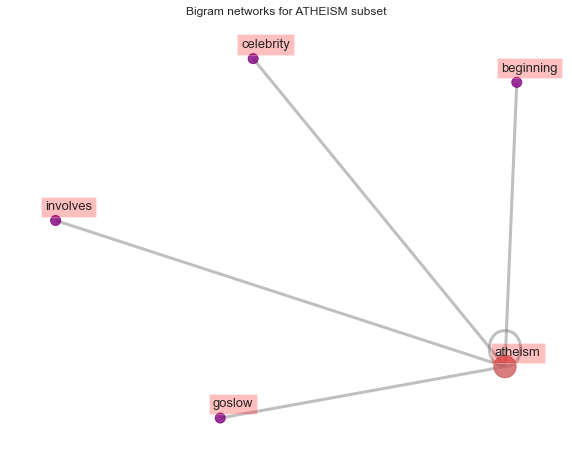

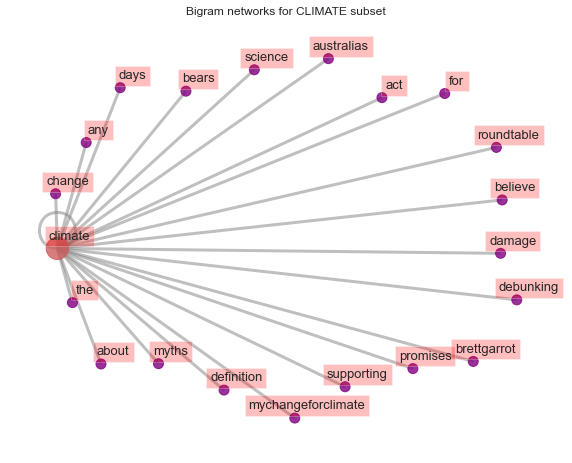

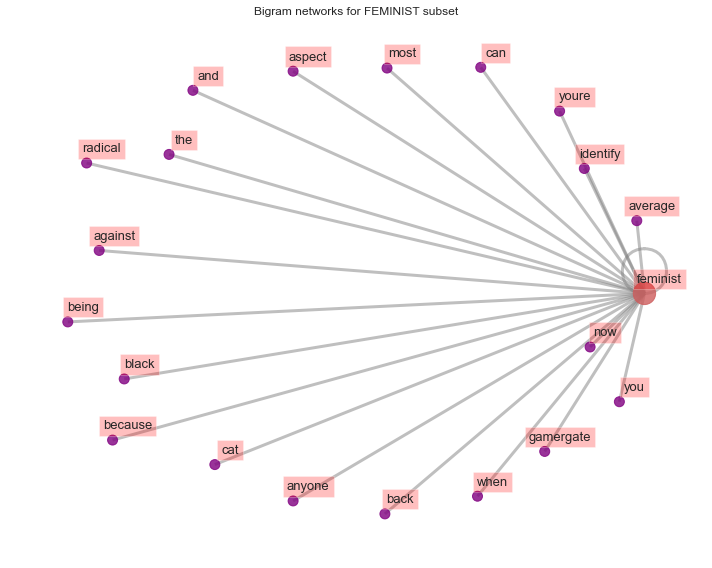

In [15]:
# plot each subset on subplot
for i, subset in enumerate(subset_names):
    df = train_named[subset] # only use training sets
    
    top_bigrams = get_top_bigrams(df['text'], subset)
    bigrams_df = pd.DataFrame(top_bigrams, columns=['bigram', 'frequency'])

    # create dictionary of bigrams and their counts
    d = bigrams_df.set_index('bigram').T.to_dict('records')

    G = nx.Graph()

    # create connections
    for k, v in d[0].items():
        if subset in k:
            G.add_edge(subset, k[0], weight=(v * 10))
            G.add_edge(subset, k[1], weight=(v * 10))
        else:
            G.add_edge(k[0], k[1], weight=(v * 10))

    node_colors = ['indianred' if n == subset else 'purple' for n in G.nodes()]
    node_sizes = [500 if n == subset else 100 for n in G.nodes()]

    fig, ax = plt.subplots(figsize=(10, 8))

    pos = nx.spring_layout(G, k=2)

    # plot
    nx.draw_networkx_nodes(G, pos,
                           node_color=node_colors,
                           node_size=node_sizes,
                           alpha=0.8)

    nx.draw_networkx_edges(G, pos, width=3, edge_color='grey', alpha=0.5)

    # offset labels
    for key, value in pos.items():
        x, y = value[0]+.05, value[1]+.05
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.25),
                horizontalalignment='center', fontsize=13)

    ax.set_title(f'Bigram networks for {subset.upper()} subset')
    plt.axis('off')

plt.tight_layout()
plt.show()
